In [84]:
import numpy as np
import faiss
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
import pandas as pd
import tiktoken
from openai.embeddings_utils import get_embedding
import openai
import os
from dotenv import load_dotenv
load_dotenv('../.env')
openai.api_key = os.getenv("OPENAI_API_KEY")

In [31]:
digits = load_digits()
print("shape", digits.data.shape)

shape (1797, 64)


In [55]:
# load from csv
df = pd.read_csv('enneads_with_embedding.csv')
ennead_matrix = np.array(df.embedding.apply(eval).to_list())
ennead_embedding_matrix = ennead_matrix.astype('float32')

In [23]:
def draw_mnist(arr):
    plt.figure(figsize=(len(arr)*4,4))
    for index, (image) in enumerate(zip(arr)):
        plt.subplot(1, len(arr), index + 1)
        plt.imshow(np.reshape(image, (8,8)), cmap=plt.cm.gray)


In [63]:
# enneads indexing
ennead_dimension = 1536 # dimension
ennead_database_size = 100 # database size
ennead_query_size = 10 # nb of queries

ennead_query = ennead_embedding_matrix[3:4] # Use the third section as a query vector
print(ennead_query)

print('embedding matrix shape: ', ennead_embedding_matrix.shape, '\nquery shape:', ennead_query.shape)

[[-0.010854   -0.00717103  0.01280301 ... -0.00254044 -0.02389895
  -0.03306605]]
embedding matrix shape:  (652, 1536) 
query shape: (1, 1536)


In [65]:
# mnist indexing
d = 64                           # dimension
nb = 100                      # database size
nq = 10                     # nb of queries

xb = digits.data.astype('float32') 
xq = digits.data[0:1].astype('float32') # Use the first image as the query vector

print('xb.shape : ', xb.shape, '\nxq.shape : ', xq.shape)

xb.shape :  (1797, 64) 
xq.shape :  (1, 64)


In [66]:
index = faiss.IndexFlatL2(d)   # build the index
print('index.is_trained : ', index.is_trained)

index.add(xb)                  # add vectors to the index
print('index.ntotal : ', index.ntotal)

index.is_trained :  True
index.ntotal :  1797


In [117]:
ennead_index = faiss.IndexFlatIP(ennead_dimension)   # build the index
print('ennead_index.is_trained : ', ennead_index.is_trained)
ennead_index.add(ennead_embedding_matrix) # add vectors to the index
print('index.ntotal : ', ennead_index.ntotal)

ennead_index.is_trained :  True
index.ntotal :  652


In [68]:
index = faiss.IndexFlatL2(d)   # build the index
print('index.is_trained : ', index.is_trained)

index.add(xb)                  # add vectors to the index
print('index.ntotal : ', index.ntotal)

index.is_trained :  True
index.ntotal :  1797


In [69]:
k = 10
D, I = index.search(xq, k)
print('I[:5] : ', I[:k])                   # neighbors of the 5 first queries
print('D[:5] : ', D[:k])                   # distances of the 5 first queries

I[:5] :  [[   0  877 1365 1541 1167 1029  464  957 1697  855]]
D[:5] :  [[  0. 120. 164. 172. 176. 178. 181. 238. 245. 252.]]


In [70]:
type(ennead_query)
type(xq)

numpy.ndarray

In [71]:
ennead_matrix.data[3:4]

In [87]:
def get_embedding_using_ada(text):
  embedding_model = "text-embedding-ada-002"
  # embedding_encoding = "cl100k_base"
  # encoding = tiktoken.get_encoding(embedding_encoding)
  # max_tokens = 8000  # the maximum for text-embedding-ada-002 is 8191
  embedding = get_embedding(text, embedding_model)
  return embedding

In [127]:
x = get_embedding_using_ada("In the Enneads, Plotinus stresses the importance of the cultivation of virtue in the pursuit of the highest good. He argues that the soul's journey towards union with the divine requires the development of virtues such as wisdom, courage, justice, and moderation. By embracing these virtues, the soul can transcend the limitations of the material world and attain a state of divine consciousness. The soul must strive to embody the highest ideals, and in doing so, it will find meaning and purpose in its existence. The journey towards divine union requires discipline and effort, but it leads to a state of supreme happiness and fulfillment. So, my friend, turn your attention to the cultivation of virtue and you will find the direction you seek.")
ennead_query_vector = np.array(x).astype('float32')

In [128]:
k = 10
distances, neighbors = ennead_index.search(np.array([ennead_query_vector]), k)
index_array = neighbors[0]
search_results = df.loc[index_array]
search_results.combined.to_json('search_results.json', orient='index', indent=2)

In [129]:
search_results[['combined']].head(10)

,combined
19,Plotinus:\nTHE FIRST ENNEAD\nTractate Title: S...
148,Plotinus:\nTHE SECOND ENNEAD\nTractate Title: ...
15,Plotinus:\nTHE FIRST ENNEAD\nTractate Title: S...
440,Plotinus:\nTHE FIFTH ENNEAD\nTractate Title: N...
57,Plotinus:\nTHE FIRST ENNEAD\nTractate Title: S...
18,Plotinus:\nTHE FIRST ENNEAD\nTractate Title: S...
16,Plotinus:\nTHE FIRST ENNEAD\nTractate Title: S...
598,Plotinus:\nTHE SIXTH ENNEAD\nTractate Title: S...
62,Plotinus:\nTHE FIRST ENNEAD\nTractate Title: S...
13,Plotinus:\nTHE FIRST ENNEAD\nTractate Title: S...


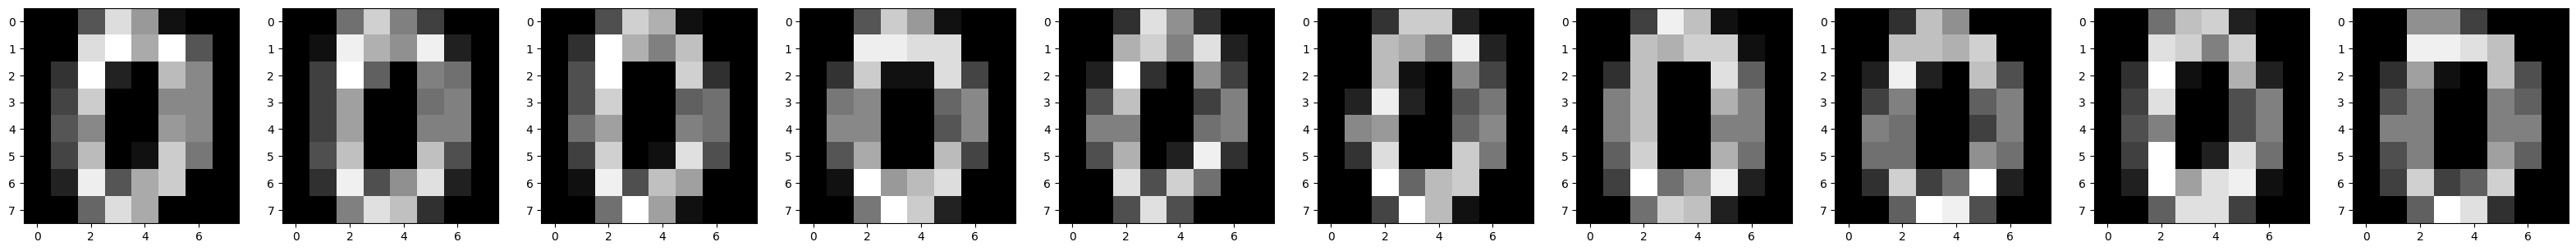

In [29]:
k = 10
D, I = index.search(xq, k)
arr = np.empty([0,64])
i = 0
for i in range(k):
    arr = np.vstack((arr, xb[I[0,i]]))
draw_mnist(arr)